In [2]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Spam", "NotSpam"]

In [2]:
import pandas as pd
data1=pd.read_csv('metadata',names = ['reviewerID' , 'asin', 'overall' , 'label','reviewTime'],  sep="\t")
data2=pd.read_csv('reviewContent',names = ['reviewerID' , 'asin', 'reviewTime' , 'reviewText'],  sep="\t")
raw_data_df=data1.merge(data2)
raw_data_df=raw_data_df.sample(30000,random_state=7)

In [3]:
raw_data_df=raw_data_df.reset_index(drop=True)
raw_data_df.head()

,reviewerID,asin,overall,label,reviewTime,reviewText
0,152768,4686,3.0,1,2014-08-09,Ate lunch here today for the first time. Food ...
1,13685,3494,4.0,1,2014-07-09,This place was kinda hard to find. But after w...
2,10289,2725,5.0,1,2012-08-01,"For the summer, my brother is lucky enough to ..."
3,49246,1401,5.0,1,2009-02-13,Randomly stopped in here last night (Thursday)...
4,127411,1881,4.0,1,2009-10-16,YUM this place is so goooood. I only recently ...


In [4]:
#Create independent and Dependent Features
columns = raw_data_df.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["label"]]
# Store the variable we are predicting 
target = "label"
# Define a random state 
state = np.random.RandomState(42)
X = raw_data_df[columns]
Y = raw_data_df[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(30000, 5)
(30000,)


In [5]:
raw_data_df.isnull().values.any()

False

Text(0,0.5,'Frequency')

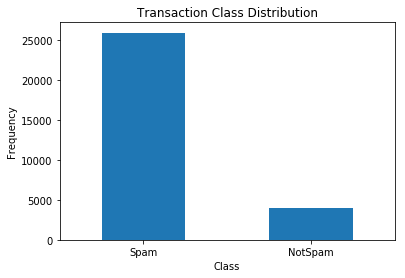

In [6]:
count_classes = pd.value_counts(raw_data_df['label'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [7]:
## Get the Spam and the Notspam dataset 

Spam = raw_data_df[raw_data_df['label']==1]

NotSpam = raw_data_df[raw_data_df['label']==-1]

In [8]:
print(Spam.shape,NotSpam.shape)

(25964, 6) (4036, 6)


In [9]:
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [10]:
os =  RandomOverSampler(ratio=1.0)

In [11]:
X_train_res, y_train_res = os.fit_sample(X, Y)

In [12]:
X_train_res.shape,y_train_res.shape

((51928, 5), (51928,))

In [13]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({1: 25964, -1: 4036})
Resampled dataset shape Counter({1: 25964, -1: 25964})


In [14]:
raw_data_df.reset_index(drop=True)
data=np.column_stack((X_train_res, y_train_res))
ready_data=pd.DataFrame(data,columns=['reviewerID' , 'asin','overall', 'reviewTime' , 'reviewText','label'])
ready_data = ready_data[['reviewerID', 'asin','overall','label','reviewTime','reviewText']]
ready_data.head()

,reviewerID,asin,overall,label,reviewTime,reviewText
0,152768,4686,3,1,2014-08-09,Ate lunch here today for the first time. Food ...
1,13685,3494,4,1,2014-07-09,This place was kinda hard to find. But after w...
2,10289,2725,5,1,2012-08-01,"For the summer, my brother is lucky enough to ..."
3,49246,1401,5,1,2009-02-13,Randomly stopped in here last night (Thursday)...
4,127411,1881,4,1,2009-10-16,YUM this place is so goooood. I only recently ...


Text(0,0.5,'Frequency')

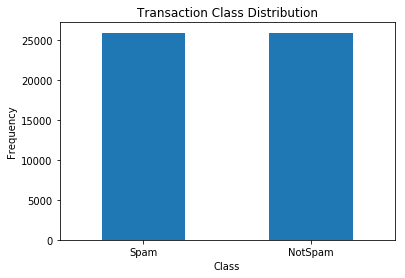

In [15]:
count_classes = pd.value_counts(ready_data['label'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [30]:
ready_data.to_csv('./raw_data_back.csv', sep = '\t',index=False)

In [57]:
data=pd.read_csv("./raw_data_back_model.csv",sep='\t')
data.head()

,reviewerID,asin,overall,label,reviewTime,reviewText,ordinal
0,152768,4686,3.0,-1,2014-08-09,Ate lunch here today for the first time. Food ...,735454
1,13685,3494,4.0,-1,2014-07-09,This place was kinda hard to find. But after w...,735423
2,10289,2725,5.0,-1,2012-08-01,"For the summer, my brother is lucky enough to ...",734716
3,49246,1401,5.0,-1,2009-02-13,Randomly stopped in here last night (Thursday)...,733451
4,127411,1881,4.0,1,2009-10-16,YUM this place is so goooood. I only recently ...,733696


In [28]:
data.dtypes

reviewerID      int64
asin            int64
overall       float64
label           int64
reviewTime     object
reviewText     object
ordinal         int64
dtype: object

C:\Users\kafee\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


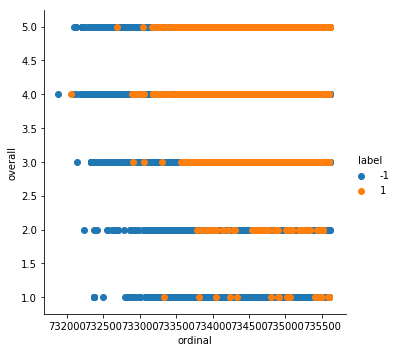

In [58]:
import seaborn as sns
data=data.drop(['reviewerID', 'asin' , 'reviewTime' , 'reviewText'], axis=1)
sns.FacetGrid(data,hue="label",size=5).map(plt.scatter,"ordinal","overall").add_legend();
plt.show()

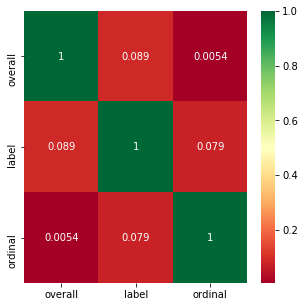

In [29]:
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(5,5))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [51]:
y = data.iloc[:,-2]  #independent columns
X = data.loc[:,["overall","ordinal"]]    #target column i.e price range

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

C:\Users\kafee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [46]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[0.04460349 0.95539651]


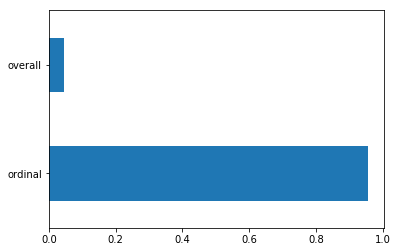

In [48]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(2).plot(kind='barh')
plt.show()

In [ ]:
import pandas as pd
data1=pd.read_csv('Daraz_Distributed_Soft_Label_Final',sep="\t")
data2=pd.read_csv('reviewContent',names = ['reviewerID' , 'asin', 'reviewTime' , 'reviewText'],  sep="\t")
raw_data_df=data1.merge(data2)
raw_data_df=raw_data_df.sample(30000,random_state=7)